# Week 1 - Tasks

- **Data Source:** `yfinance`
- **Assets:** `AAPL`, `MSFT`, `GOOG`, `AMZN`, `TSLA` (and `NVDA` for Task 5)
- **Timeframes:**
  * **Long Term:** `start="2015-01-01", end="2024-01-01"`
  * **Medium Term:** `start="2020-01-01", end="2024-01-01"` (Includes COVID crash)

The goal for this week is to gain familiarity with financial data, analyze common trends, learn standard library functions, and touch upon the underlying theory.

In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# some global stylistic settings
plt.style.use("seaborn-v0_8-talk")
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3
plt.rcParams["axes.edgecolor"] = "0.3"
plt.rcParams["axes.linewidth"] = 0.8
tickers = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA"]



## Task 1 - Setup
* Fetch **Long Term** historical data for the 5 assets.
* Extract the `Adjusted Close` values.
    * *Note: Check for missing values or empty rows and handle them (drop or fill).*
* Use `df.describe()` to extract key summary statistics.
* Extract the **Medium Term** data as well for later tasks.

In [22]:
long_term_data=yf.download(tickers,start="2015-01-01",end="2024-01-01", auto_adjust=False)
medium_term_data=yf.download(tickers,start="2020-01-01",end="2024-01-01", auto_adjust=False)
long_term_data.ffill().bfill()
medium_term_data.ffill().bfill()
adj_close_long=long_term_data['Adj Close']
adj_close_medium=medium_term_data['Adj Close']


print(adj_close_long.describe())

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed

Ticker         AAPL         AMZN         GOOG         MSFT         TSLA
count   2264.000000  2264.000000  2264.000000  2264.000000  2264.000000
mean      81.394710    91.950540    73.063479   154.516907   102.886245
std       55.990880    48.654536    36.298158    99.658477   110.936400
min       20.604073    14.347500    24.377234    34.437160     9.578000
25%       32.814694    44.303625    41.515250    59.182489    16.670500
50%       51.220844    90.691998    59.376665   127.528812    23.160666
75%      139.017616   133.230000   104.133984   244.037388   214.290005
max      196.256561   186.570496   149.587067   377.077850   409.970001


## Task 2 - Basic Trends
* Select **one asset** and using the **Medium Term** data, compute:
    * **Returns:** 1-day, 5-day, and 20-day simple returns.
    * **Log Returns:** 1-day, 5-day, and 20-day log returns.
    * **Volatility:** 5-day, 20-day, and 60-day rolling standard deviation (volatility) of the log returns.
* **Plotting:**
    * Plot the price and the 20-day moving average on one chart.
    * Plot the 1-day log returns on a separate chart.
    * Plot the rolling volatilities on a third chart.
    * *Analysis:* What trends do you observe? Does high volatility correlate with price drops?

* **Bonus (Long Term Data):**
    * Create a scatter plot of `|Daily Return|` vs `Volume`. Is there a relationship?
    * Group returns and volatility by **Month** (e.g., all Januaries, all Februaries) and plot the averages. Is there a "seasonal" effect?

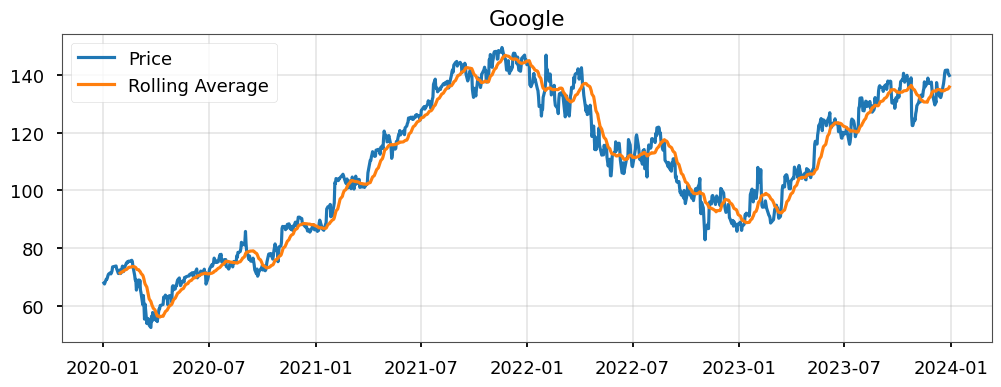

In [23]:
google_med_data=adj_close_medium['GOOG']
google_long_data=adj_close_long['GOOG']
returns1=google_med_data.diff().dropna()
returns5=google_med_data.diff(5).dropna()
returns20=google_med_data.diff(20).dropna()

logret1=np.log(google_med_data).diff().dropna()
logret5=np.log(google_med_data).diff(5).dropna()
logret20=np.log(google_med_data).diff(20).dropna()

roll_vol5=logret1.rolling(5).std().dropna()
roll_vol20=logret5.rolling(20).std().dropna()
roll_vol60=logret20.rolling(60).std().dropna()

roll_avg5=google_med_data.rolling(5).mean().dropna()
roll_avg20=google_med_data.rolling(20).mean().dropna()
roll_avg60=google_med_data.rolling(60).mean().dropna()

plt.plot(google_med_data, label="Price")
plt.plot(roll_avg20, label="Rolling Average")
plt.title("Google")
plt.legend()
plt.show()


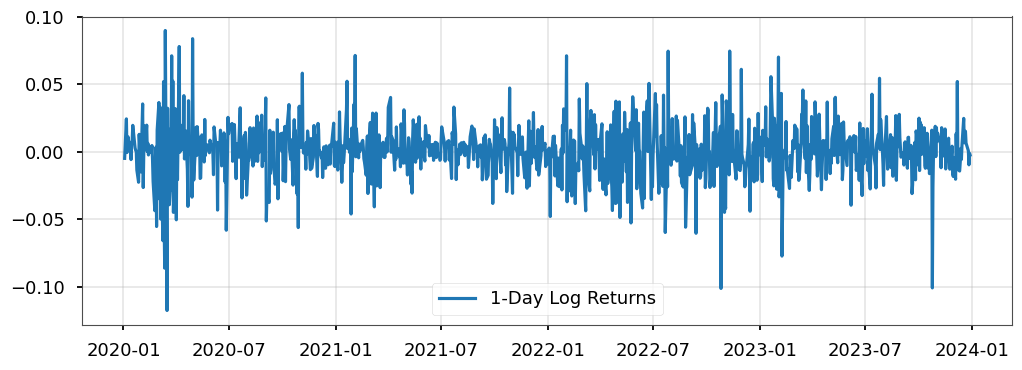

In [24]:
plt.plot(logret1, label="1-Day Log Returns")
plt.legend()
plt.show()

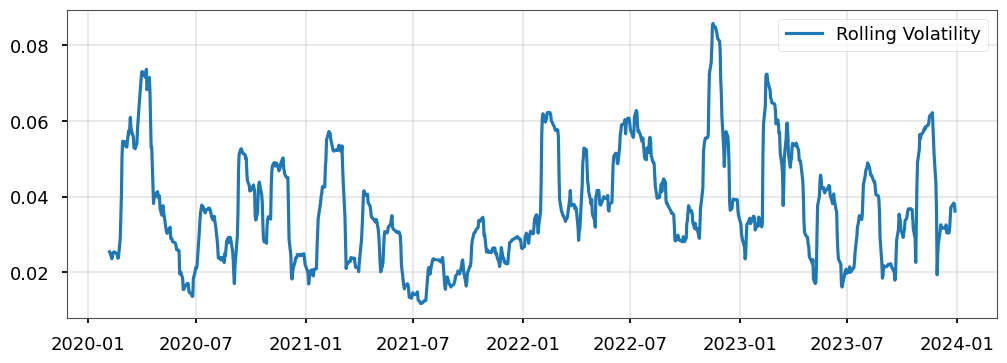

In [25]:
plt.plot(roll_vol20, label="Rolling Volatility")
plt.legend()
plt.show()


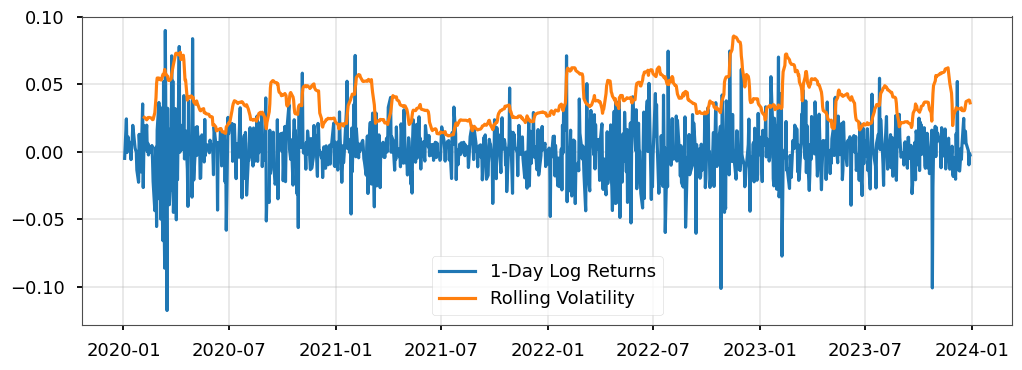

In [26]:
#BOTH IN SAME CHART FOR COMPARISON
plt.plot(logret1, label="1-Day Log Returns")
plt.plot(roll_vol20, label="Rolling Volatility")
plt.legend()
plt.show()


**Analysis**:
The one day log returns show the magnitude of fluctuations, not necessarily which direction they're in. That is, 1-day log returns and 20-day rolling volatility are not completely correlated. However, whenever returns experience large spikes (positive or negative), volatility rises shortly after because of the rolling window.  

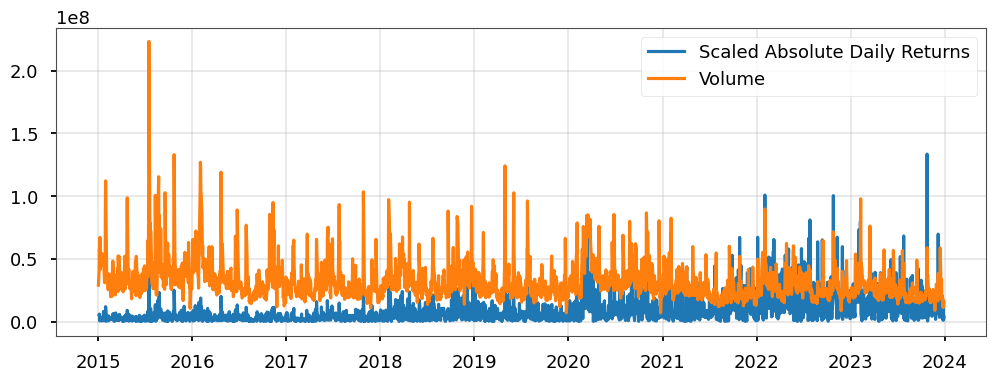

In [28]:

volume=long_term_data['Volume']['GOOG']
moddailyreturn=google_long_data.diff().dropna().abs()
plt.plot(moddailyreturn*1e7, label="Scaled Absolute Daily Returns")
plt.plot(volume, label="Volume")
plt.legend()
plt.show()

**Comment:**
The chart shows that spikes in absolute daily returns often coincide with spikes in trading volume, especially during periods of market stress or major news. This suggests a positive correlation between volatility and volume: when prices move sharply (large returns), more traders participate, increasing volume. However, the relationship is not perfectly aligned - many volume increases occur without large return spikes, meaning volume reacts to more than just price volatility.

## Task 3 - Stationarity
* Select **one asset** (Long Term).
* Compute the **Rolling Mean** and **Rolling Standard Deviation** of log returns with window sizes `20, 60, 120`.
* Plot them and visually inspect.
    * Does the mean stay constant? (Stationary mean)
    * Does the variance stay constant? (Stationary variance)
* Run an **Augmented Dickey-Fuller (ADF) Test** on the log return series.
    * Library: `from statsmodels.tsa.stattools import adfuller`
    * *Goal:* Interpret the p-value. The Null Hypothesis ($H_0$) is that the series is non-stationary (has a unit root). If p-value < 0.05, we reject $H_0$.
    * For learning about hypothesis testing and p-value you can refer to CS215 slides or other standard resources mentioned in READMEs.

In [29]:
google_longterm_data=long_term_data.xs('GOOG', level=1, axis=1)
google_longterm_data.ffill().bfill()
google_longterm_close=google_longterm_data['Adj Close']


google_longterm_logreturns=np.log(google_longterm_close).diff().dropna()

rolling_mean20=google_longterm_logreturns.rolling(20).mean().dropna()
rolling_std20=google_longterm_logreturns.rolling(20).std().dropna()

rolling_mean60=google_longterm_logreturns.rolling(60).mean().dropna()
rolling_std60=google_longterm_logreturns.rolling(60).std().dropna()

rolling_mean120=google_longterm_logreturns.rolling(120).mean().dropna()
rolling_std120=google_longterm_logreturns.rolling(120).std().dropna()



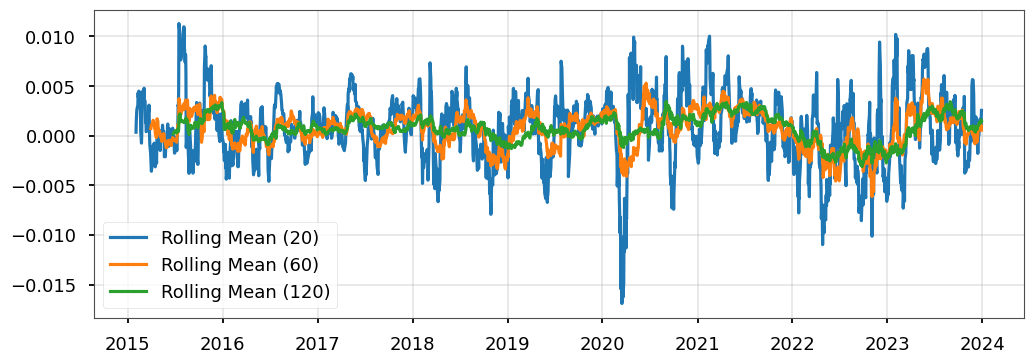

In [30]:
plt.plot(rolling_mean20, label='Rolling Mean (20)')
plt.plot(rolling_mean60, label='Rolling Mean (60)')
plt.plot(rolling_mean120, label='Rolling Mean (120)')
plt.legend()
plt.show()

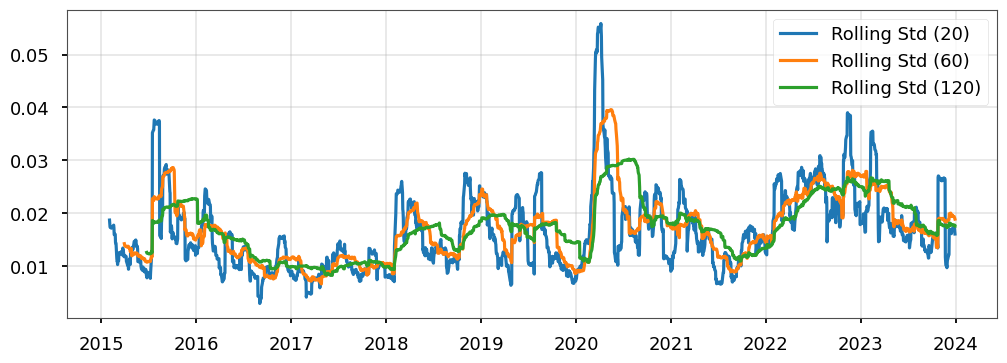

In [31]:
plt.plot(rolling_std20, label='Rolling Std (20)')
plt.plot(rolling_std60, label='Rolling Std (60)')
plt.plot(rolling_std120, label='Rolling Std (120)')
plt.legend()
plt.show()

**Comment**: Rolling means are fluctuating around zero. There is no long-term upward or downward movement, and the larger windows (60, 120) are smoother but still near zero. So in that sense, we could say the rolling means are "stationary"

Rolling volatility, on the other hand, changes a lot over time. Highs and lows are clearly observed. Hence the variance is not "stationary".

In [33]:
from statsmodels.tsa.stattools import adfuller


adf_test_result=adfuller(google_longterm_logreturns)
pvalue=adf_test_result[1]
print(f"ADF Test p-value: {pvalue}")

ADF Test p-value: 2.905966213550118e-20


**Comment**: The Augmented Dickey-Fuller test on the GOOG log return series gives a p value below 0.05. Therefore, we can reject the null hypothesis of a unit root and say that the log return series is stationary. This confirms that while stock prices are non-stationary, their log returns are stationary in mean.

## Task 4 - Volatility Regimes
We try to study the trend in volatility more deeply. From the ACF/PACF plot we know that volatility tends to cluster that is the market is either in a high volatility state (greater daily fluctuations) or low volatility state (stable prices, quiet markets).

Formally we can treat volatility as a *conditional standard deviation of returns*, conditioned on the history observed so far. We *cannot* predict *true* volatility for a given day based on the single return value, hence we try to estimate it using the past information. For this we look at two indicators of volatility:

1.  **Rolling Window Volatility:** Simple Moving Average (SMA) of standard deviation.
2.  **EWMA Volatility:** Exponentially Weighted Moving Average. This gives more weight to recent events. It is given by $\sigma_t^2 = (1-\lambda)r_t^2 + \lambda \sigma_{t-1}^2$.

**Steps:**
* Pick an asset and use data covering the **Feb-Mar 2020 COVID crash**.
* Compute two volatility estimates on the Log Returns:
    1.  **Rolling 20-day Volatility:** Standard deviation over a 20-day window.
    2.  **EWMA Volatility (RiskMetrics):** Use a decay factor $\lambda = 0.94$.
        * *Hint:* In pandas `df.ewm()`, the parameter `alpha` corresponds to $1 - \lambda$. So, use `alpha=0.06`.
* **Analysis:**
    * Plot both estimates on the same chart.
    * Which is smoother?
    * Which estimator reacts faster to the sudden crash in March 2020?
    * Which one would you prefer for risk management?
* **Regime Detection:** Compute the 60th percentile of your EWMA volatility series. Shade the regions on the plot where volatility exceeds this level.

* **Bonus:** A good volatility model "standardizes" the returns well. Calculate $z_t = r_t / \hat{\sigma}_t$. If the model is good, $z_t$ should have $Var \approx 1$. Check the variance of $z_t$ and plot its histogram.

In [ ]:
covid_data = google_longterm_logreturns.loc['2020-01-01':'2020-04-30']
rolling_vol_20 = covid_data.rolling(20).std()

ewma_var=covid_data.pow(2).ewm(alpha=0.06).mean()
ewma_vol=np.sqrt(ewma_var)

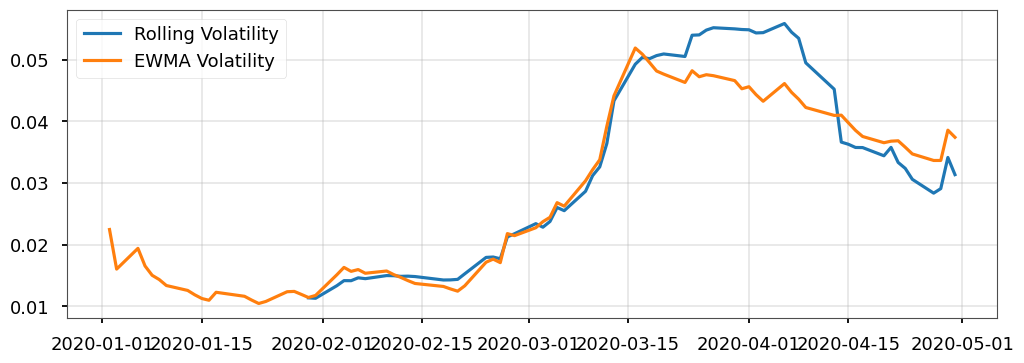

In [50]:
plt.plot(rolling_vol_20, label='Rolling Volatility')
plt.plot(ewma_vol, label='EWMA Volatility')
plt.legend()
plt.show()


**Analysis**: Rolling Volatility is probably smoother, as it weighs all past observations equally. EWMA volatility adapts faster to the crash, or atleast should, even though for some reason my graph doesn't show it that well. For risk management, we'd use EWMA because it adapts faster to market stress

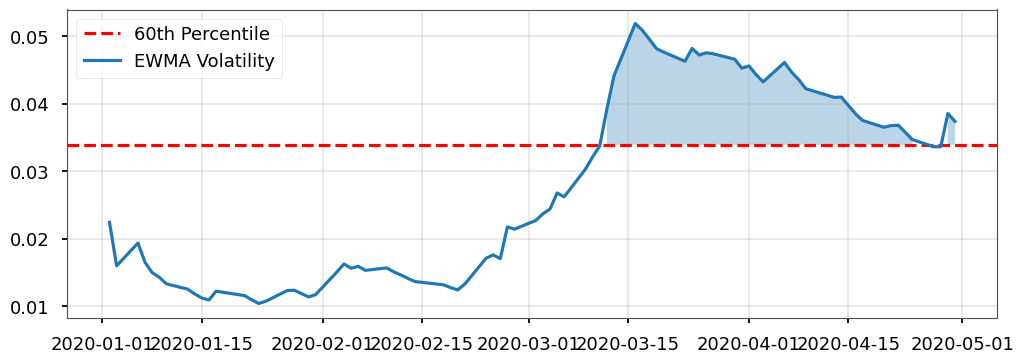

In [49]:
threshold = ewma_vol.quantile(0.60)
plt.axhline(threshold, linestyle='--', label='60th Percentile', color='red')
plt.plot(ewma_vol, label='EWMA Volatility')
plt.fill_between(
    ewma_vol.index,
    ewma_vol,
    threshold,
    where=(ewma_vol >= threshold),
    alpha=0.3
)
plt.legend()

plt.show()

## Task 5 - Time Horizons and the "Normal" Illusion
Short-term markets are noisy and dangerous (fat tails), while long-term data looks smoother. We can prove this statistically using **Skew** and **Kurtosis**.

**Theory:**
* **Skewness:** Measures asymmetry. (Negative skew = frequent small gains, few extreme losses).
* **Kurtosis:** Measures "tailedness". (High kurtosis = frequent extreme events/crashes).
* **Normal Distribution:** Skew $\approx 0$, Kurtosis $\approx 3$ (or Excess Kurtosis $\approx 0$).

**Steps:**
1.  Take your **Long Term** data for one asset (e.g., NVDA or TSLA).
2.  Resample the prices to get **Weekly** and **Monthly** closes.
    * Use `df['Adj Close'].resample('W').last()` and `...resample('M').last()`.
3.  Compute Log Returns for all three series: Daily, Weekly, Monthly.
4.  **The Test:**
    * Calculate **Skew** and **Kurtosis** for each of the three return series.
    * *Question:* How do these values change as the time horizon increases? Do they get closer to 0 and 3?
5.  **Visualization:**
    * Plot the **Histograms** of the Daily returns vs. Monthly returns on the same plot.
    * *Tip:* You will need to standardize them (subtract mean, divide by std dev) to overlay them meaningfully.
    * *Observation:* Look at the tails. Which one has "fatter" tails (more extreme outliers)?

**Key Takeaway:**
Daily returns often violate the "Normal Distribution" assumption used in many financial models. Long-term returns fit it better. This is called *Aggregational Gaussianity*.

**Bonus:** This is a direct application of a simple yet well-known result in asymptotic statistics. Can you find out what it is and state how it explains this observation?

In [104]:
aapl_longterm_data=yf.download("TSLA",start="2015-01-01",end="2024-01-01", auto_adjust=False)
aapl_longterm_data.ffill().bfill()
prices=aapl_longterm_data['Adj Close']

prices_weekly=prices.resample('W').last()
prices_monthly=prices.resample('M').last()

ret_daily=np.log(prices).diff().dropna()
ret_weekly=np.log(prices_weekly).diff().dropna()
ret_monthly=np.log(prices_monthly).diff().dropna()

[*********************100%***********************]  1 of 1 completed
C:\Users\parth\AppData\Local\Temp\ipykernel_28148\3509740795.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  prices_monthly=prices.resample('M').last()


In [105]:
skew=[float(ret_daily.skew()), float(ret_weekly.skew()), float(ret_monthly.skew()   )]
kurtosis=[float(ret_daily.kurtosis()+3), float(ret_weekly.kurtosis()+3), float(ret_monthly.kurtosis()+3)]

print("Skewness (Daily, Weekly, Monthly):", skew)
print("Kurtosis (Daily, Weekly, Monthly):", kurtosis)

Skewness (Daily, Weekly, Monthly): [-0.16334633334737622, 0.07815539980878194, 0.39973677069450564]
Kurtosis (Daily, Weekly, Monthly): [7.517238951229089, 4.332059301369952, 3.6908810654389046]


C:\Users\parth\AppData\Local\Temp\ipykernel_28148\2915556146.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  skew=[float(ret_daily.skew()), float(ret_weekly.skew()), float(ret_monthly.skew()   )]
C:\Users\parth\AppData\Local\Temp\ipykernel_28148\2915556146.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  kurtosis=[float(ret_daily.kurtosis()+3), float(ret_weekly.kurtosis()+3), float(ret_monthly.kurtosis()+3)]


**Comment**: As the time horizon increases, skewness moves closer to zero and kurtosis moves closer to three. This indicates that return distributions become more symmetric and less heavy-tailed at longer horizons.

In [106]:
daily_std=(ret_daily-ret_daily.mean())/ret_daily.std()
monthly_std=(ret_monthly-ret_monthly.mean())/ret_monthly.std()

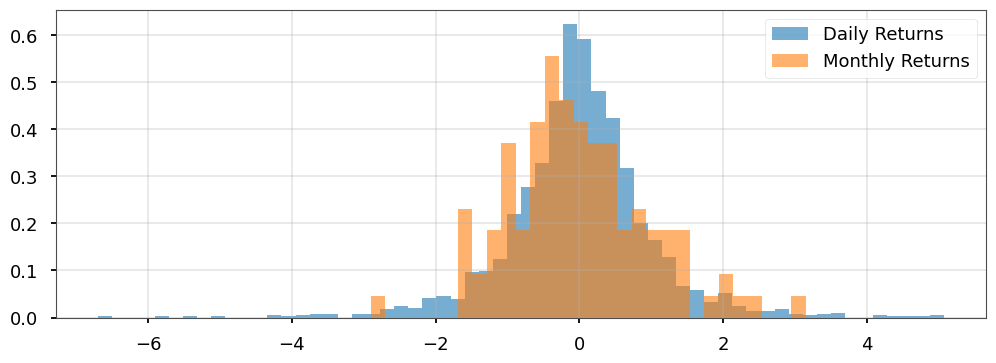

In [107]:

plt.hist(daily_std, bins=60, density=True, alpha=0.6, label='Daily Returns')
plt.hist(monthly_std, bins=30, density=True, alpha=0.6, label='Monthly Returns')
plt.legend()
plt.show()

**Comments**: Daily returns have significantly fatter tails than monthly returns, indicating a higher probability of extreme outcomes.

## Task 6 - Smart investing
Calculate how many **RTX 4090s** (approx. price $1,600$) you could afford *today* if you had invested **$1,000** in NVIDIA on the day you were born.

In [90]:
data = yf.download(
    'NVDA',
    start="2006-12-29",
    auto_adjust=True,
    progress=False
)
price = data.loc["2006-12-29"]["Close"] #cus i was born on sunday
shares=int(1000/price)
print("Shares:",shares)

log_returns=np.log(data["Close"]).diff().dropna()
log_returns_since_birth=log_returns.loc["2006-12-29":]
total_return=log_returns_since_birth.sum()
final_value=1000*np.exp(total_return)

number_of_gpus=int(final_value/1600)

print("Number of GPUs:",number_of_gpus)

Shares: 1768
Number of GPUs: 193


C:\Users\parth\AppData\Local\Temp\ipykernel_28148\1673227407.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  shares=int(1000/price)
C:\Users\parth\AppData\Local\Temp\ipykernel_28148\1673227407.py:16: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  number_of_gpus=int(final_value/1600)
